In [204]:
library(caret)
country.code <- 'us'  # use yours
url.pattern <- 'https://'  # use http if you want
repo.data.frame <- subset(getCRANmirrors(), CountryCode == country.code & grepl(url.pattern, URL))
options(repos = repo.data.frame$URL)

# Background:

An consulting organization seeks to predict the unit cost of a given product based on a number of variables in order to reduce the amonut of time they spend estimating supplier costs. Currently, when a request comes in, stakeholders contact a variety of vendors for cost estimates and combine this information with their own experience in order to provide an accurate cost estimate for their organization. 

# Variables

* DV
  * CPU: Cost Per Unit
* IV
  * Length: Product Length
  * Incidence: Availability of product
  * Region: Source of product
  * Language: Language of product
  
Note: All other variables are not reliable

In [267]:
## Source Data

source <- read.csv('cpi.csv')    
country_map <- read.csv('country_map.csv')
cols_to_drop = c('Methodology', 'Total.Quota', 'Max.Feasibility', 'Internet.Penetration', 'Recommended...Online', 'Translation.with.Edit', 'Comment.One', 'Comment.Two', 'Comment.Three', 'Country', 'OrigCountryCount')
df <- drop_cols(merge(source, country_map, on='Country'), cols_to_drop)

head(df)

## Data Transformations

drop_cols <- function(df, cols_to_drop){
    for (col in cols_to_drop){
        df[[col]] = NULL
    }
    return(df)
}

df$Language <- ifelse(df$Language != 'English', 'Other', 'English')
df$Incidence <- (df$Incidence) * 100
df$I2 <- (df$Incidence ^ 2)
#df$HighCost <- ifelse(df$CPI >= 15, 1, 0)
df$IncLength <- (df$Incidence * df$Length) / 10

head(df)

Length,Incidence,CPU,Language,Region
15,0.60,6.0,Spanish,South America
30,0.60,9.0,Spanish,South America
10,0.20,15.0,English,Other
10,0.35,13.0,English,Other
15,0.10,22.0,English,Other
15,0.20,15.5,English,Other


Length,Incidence,CPU,Language,Region,I2,IncLength
15,60,6.0,Other,South America,3600,90
30,60,9.0,Other,South America,3600,180
10,20,15.0,English,Other,400,20
10,35,13.0,English,Other,1225,35
15,10,22.0,English,Other,100,15
15,20,15.5,English,Other,400,30


In [301]:
# Fit model

set.seed(998)
inTraining <- createDataPartition(df$CPU, p = .5, list = FALSE)
train_df <- df[inTraining, ]
test_df <- df[-inTraining, ]

set.seed(42)

model <- train(
    CPU ~ ., train_df,
    method = 'lm',
    trControl = trainControl(
        method = 'cv', number = 20,
        repeats = 5, verboseIter = TRUE
    )
)

+ Fold01: intercept=TRUE 
- Fold01: intercept=TRUE 
+ Fold02: intercept=TRUE 
- Fold02: intercept=TRUE 
+ Fold03: intercept=TRUE 
- Fold03: intercept=TRUE 
+ Fold04: intercept=TRUE 
- Fold04: intercept=TRUE 
+ Fold05: intercept=TRUE 
- Fold05: intercept=TRUE 
+ Fold06: intercept=TRUE 
- Fold06: intercept=TRUE 
+ Fold07: intercept=TRUE 
- Fold07: intercept=TRUE 
+ Fold08: intercept=TRUE 
- Fold08: intercept=TRUE 
+ Fold09: intercept=TRUE 
- Fold09: intercept=TRUE 
+ Fold10: intercept=TRUE 
- Fold10: intercept=TRUE 
+ Fold11: intercept=TRUE 
- Fold11: intercept=TRUE 
+ Fold12: intercept=TRUE 
- Fold12: intercept=TRUE 
+ Fold13: intercept=TRUE 
- Fold13: intercept=TRUE 
+ Fold14: intercept=TRUE 
- Fold14: intercept=TRUE 
+ Fold15: intercept=TRUE 
- Fold15: intercept=TRUE 
+ Fold16: intercept=TRUE 
- Fold16: intercept=TRUE 
+ Fold17: intercept=TRUE 
- Fold17: intercept=TRUE 
+ Fold18: intercept=TRUE 
- Fold18: intercept=TRUE 
+ Fold19: intercept=TRUE 
- Fold19: intercept=TRUE 
+ Fold20: in

In [273]:
print(model)
summary(model)

Linear Regression 

616 samples
  6 predictor

No pre-processing
Resampling: Cross-Validated (20 fold) 
Summary of sample sizes: 585, 585, 585, 586, 585, 584, ... 
Resampling results:

  RMSE      Rsquared 
  2.324251  0.7731117

Tuning parameter 'intercept' was held constant at a value of TRUE
 



Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.3461 -1.3931 -0.4713  0.8255 17.4839 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           13.0141780  0.8014888  16.238  < 2e-16 ***
Length                 0.2507340  0.0297348   8.432 2.48e-16 ***
Incidence             -0.3630712  0.0237309 -15.300  < 2e-16 ***
LanguageOther          0.4623761  0.3131378   1.477   0.1403    
RegionEurope          -0.6408046  0.2546877  -2.516   0.0121 *  
`RegionNorth America` -0.7299827  0.3547041  -2.058   0.0400 *  
RegionOther            3.8105411  0.5007837   7.609 1.06e-13 ***
`RegionSouth America` -0.1488951  0.3262453  -0.456   0.6483    
I2                     0.0023568  0.0002116  11.138  < 2e-16 ***
IncLength              0.0029280  0.0065755   0.445   0.6563    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.402 on 606 degrees of freedom
Multi

In [236]:
confint(model$finalModel)

,2.5 %,97.5 %
(Intercept),9.296511368,10.851363478
Survey.Length,0.160284960,0.201743315
Incidence,-0.227238412,-0.173346462
LanguageOther,0.115547346,0.934650816
RegionEurope,-0.492537139,0.177068621
`RegionNorth America`,-0.656750759,0.274193908
RegionOther,1.599006355,2.927285060
`RegionSouth America`,-0.160050723,0.695106763
I2,0.000715078,0.001300937
HighCost,5.823497968,6.716243669


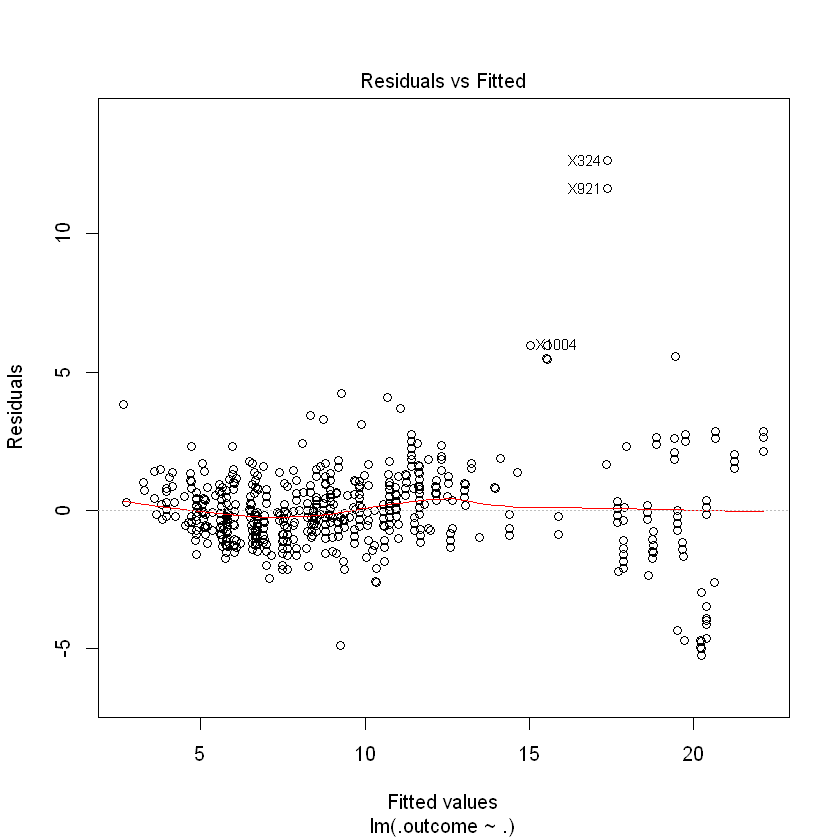

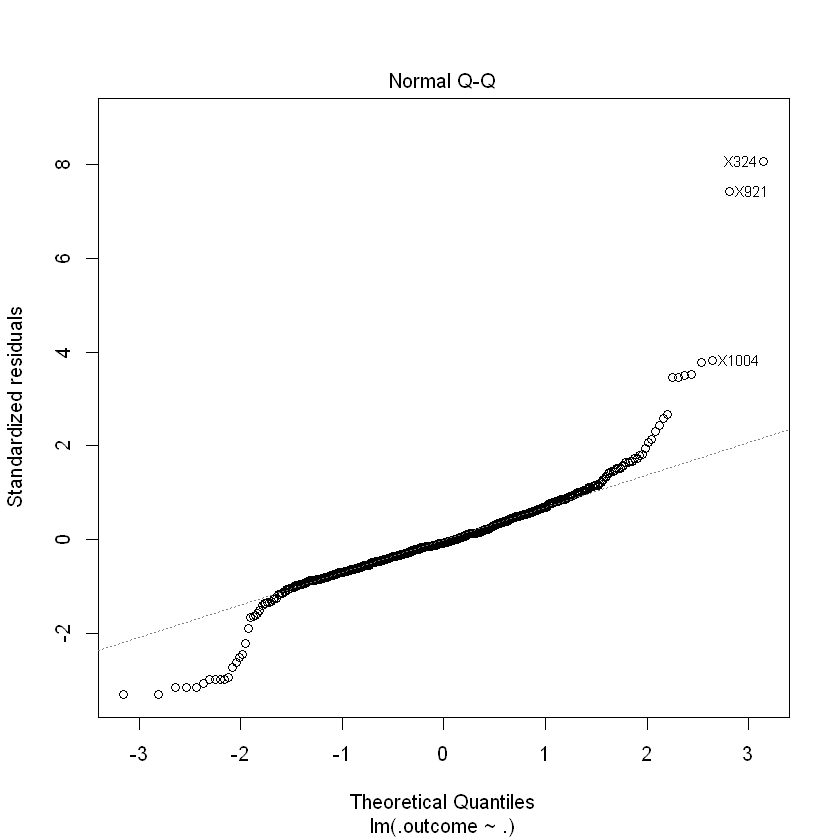

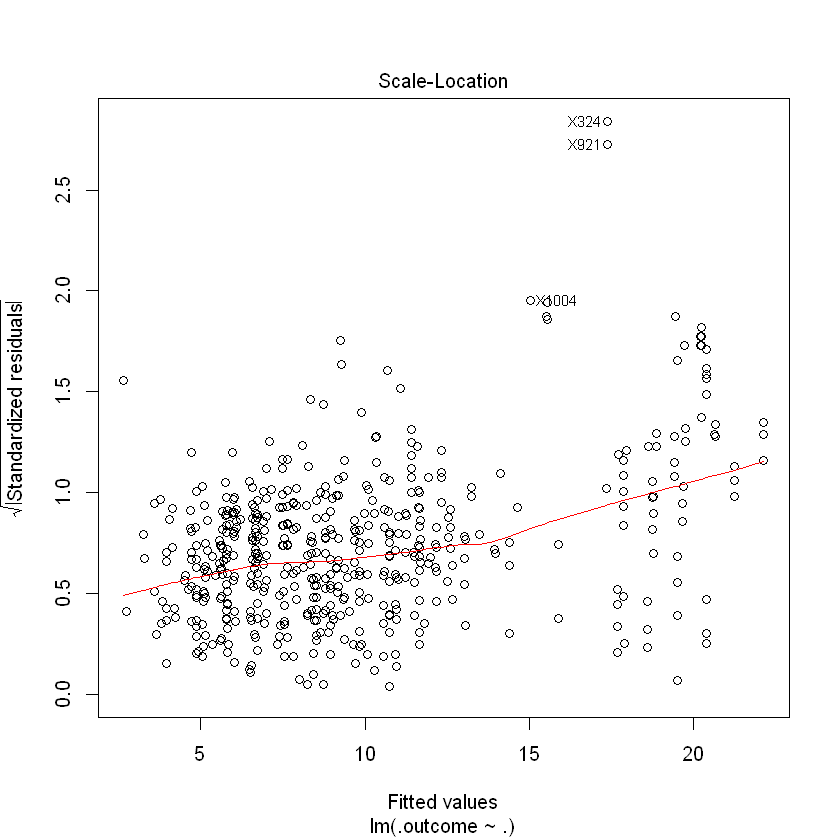

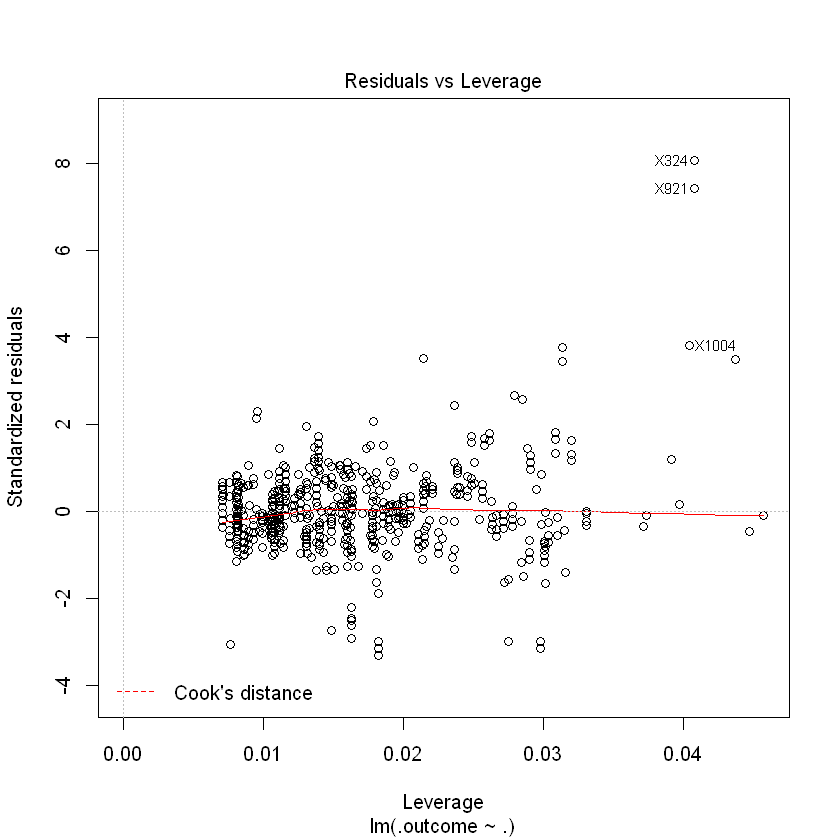

In [237]:
plot(model$finalModel)

In [308]:
# Test model
#test1 <- test_df[1,]
p <- predict(model, test_df, interval="prediction")
actuals <- test_df$CPU
error <- (p - actuals)

sqrt(mean(error ^ 2))
head(p)

[1] 2.679258

2         3         4         7        11        12 
 8.076973 13.071920  9.614143 13.091757  6.941864 18.502928

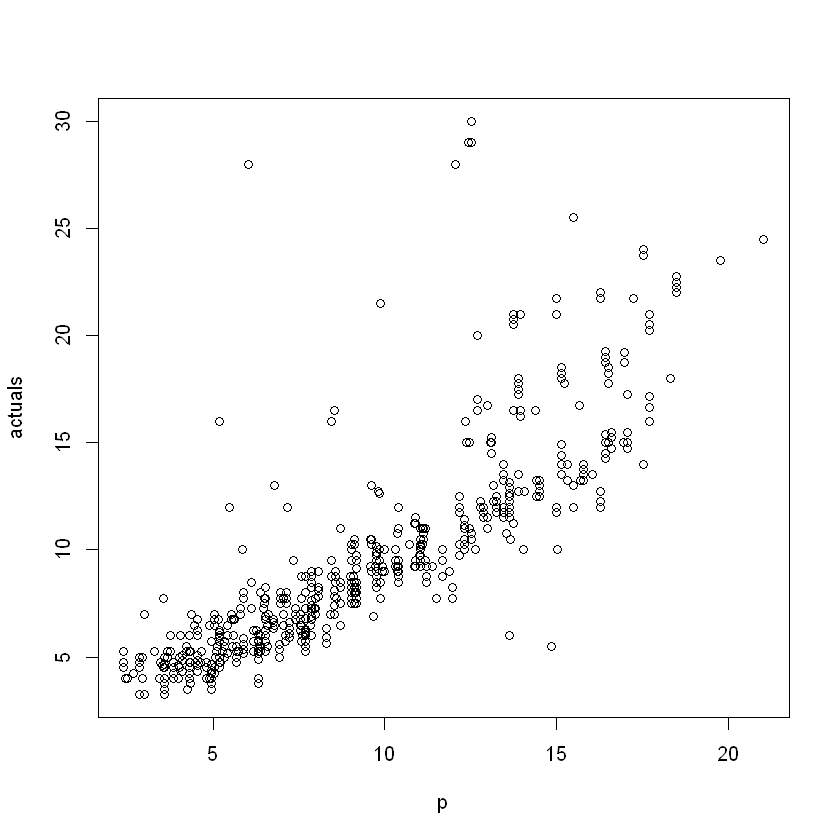

In [276]:
plot(p, actuals)

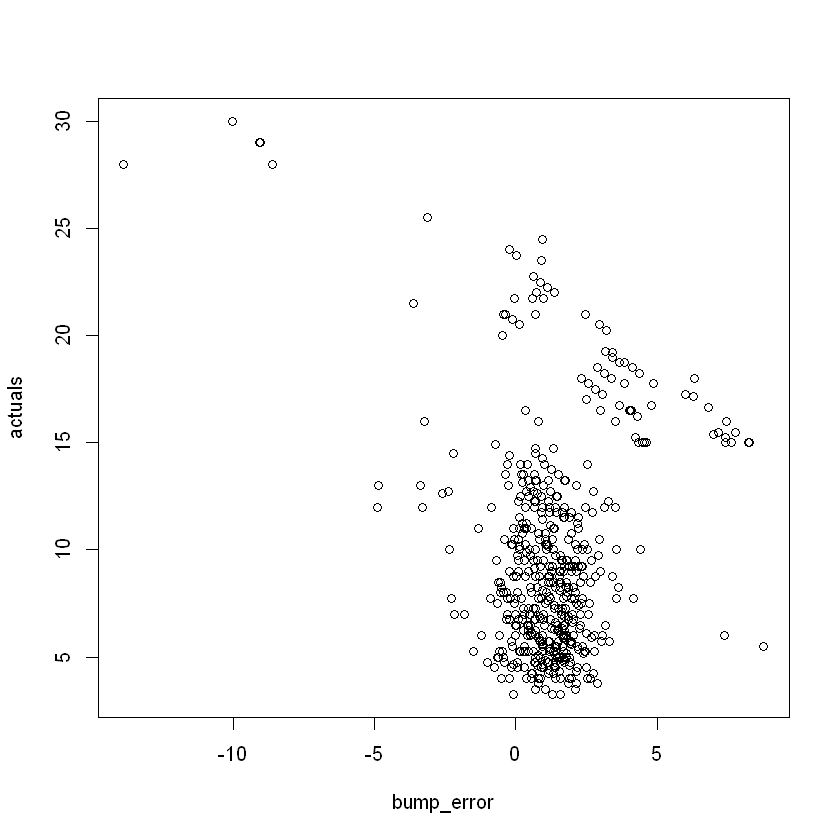

In [235]:
bump <- p * 1.15
bump_error <- bump - actuals
plot(bump_error, actuals)